# About

This script is a frontend script to produce Fisher corner plots. It takes in the different statistics, for the derivative, and applies a summary to the LoS evolution. The fiducial statistics are already prepared with the LoS evolution summarised. 

When you run 'get_fisher' or  'get_double_stat_fisher', the condition number of the covariance matrix is printed as well as a plot of the covariance multiplied by its inverse - in both a 2D plot and histogram. This is to see the error on the zero and hence the stability of the covariance matrix. 

In [1]:
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt
from astropy.io import fits
from os import listdir
import os
from scipy.fftpack import fft, dct

import sys
sys.path.insert(0, os.path.abspath('..')) # Note that this line is useless with a regular pip installation of PyWST.
import pywst as pw

import pywt
%matplotlib inline

Let's set up our directories and other parameters

In [2]:
#Where our data is 
ddir = './'

# Our parameters in the Fisher analysis
params = ['ION_Tvir_MIN','R_BUBBLE_MAX','HII_EFF_FACTOR']
# Each paramters \delta\theta
delta_params = [pow(10,4.740362689494244)-pow(10,4.653212513775344),10,10]
nparams = len(params)
# How many Simulations to use of our derivatives 
max_samples = 400
# Simu;ation dimensions 
npix = 256
box_size = 140 #Mpc
freq_channels = 128
# Min and Max redshifts 
zmin,zmax=8.813873961895457,9.372252076209087
# Number of fourier bins to remove
kbins_removed = 1 # Just the last bin

# Fisher Functions

In [3]:
def get_fisher(derivatives,fiducial,nparams):
    """ Calculates the fisher matrix for different number of derivative samples. This function also 
        plots the 'identity' matrix derived for multiplying the covariance by its inverse - we also 
        include a histogram of this 'identity' matrix to see the zero-error.

    Parameters
    ----------
    derivatives : numpy.array
        An array containing the derivatives of a given statistic, with dimensions of 
        [nparams,nsamples,ncoefficients]
    fiducial : numpy.array
        Contains the fiducial simulation's statistic, with which we calculate the
        covariance. It has dimensions [nsamples,ncoefficients].
    nparams : int
        The number of parameters for which a derivative has been calculated.
    
    Returns
    -------
    Fisher : numpy.array
        Fisher matrix for a given number of sample used to calculate derivatives.
        Dimensions of [len(samples), nparams, nparams]
        
    Fisher_Inv : numpy.array
        Inverse of the Fisher matrix,having dimensions of [len(samples), nparams, nparams].
    samples : numpy.array
        Contains the number of samples of derivatives used to calculate Fisher and Fisher_Inv
    """
    import numpy
    # Maximum number of derivative samples that can be used 
    max_samples = len(derivatives[0])
    
    ## Whitening step ##
    std_fid = np.std(fiducial,axis=0)
    white_fid = fiducial/std_fid
    #The covariance
    covariance = np.cov(white_fid,rowvar=False)
    # Whitening the derivatives
    derivatives_white = derivatives.reshape((nparams,max_samples,-1))/std_fid
    print(('Condition Number: 10^%.3f')%(np.log10(np.linalg.cond(covariance))))
    # How many samples to use
    samples = np.arange(5,max_samples+50,5)
    # Initialising Fishers 
    Fisher = np.zeros((len(samples),nparams,nparams))
    Fisher_Inv = np.zeros((len(samples),nparams,nparams))
    
    
    # Checking stability of the covariance
    plt.figure()
    I = np.log10(abs(np.matmul(np.linalg.inv(covariance),covariance))+1e-16)
    plt.imshow(I)
    plt.colorbar().set_label('log$_{10} C^{-1}C$')
    plt.figure()
    plt.hist(I.reshape(-1),bins=100)
    plt.xlabel('log$_{10} C^{-1}C$')
    plt.yscale('log')

    # Calculating the Fisher matrix for a given sample of derivatives 
    for k,sample_size in enumerate(samples):
        deriv_sample = np.mean(derivatives_white[:,:sample_size,:],axis=1)
        F_ij = np.zeros((nparams,nparams))
        for i in range(nparams):
            for j in range(nparams):
                parm_i_ps = (deriv_sample)[i]
                parm_j_ps = (deriv_sample)[j]        
                FIJ = np.dot(parm_i_ps, np.dot(np.linalg.inv(covariance),parm_j_ps))
                F_ij[i,j] = FIJ
        F_ij_inv = np.linalg.inv(F_ij)  
        Fisher[k,:,:]= F_ij
        Fisher_Inv[k,:,:] = F_ij_inv
    return Fisher,Fisher_Inv,samples

In [4]:
def get_double_stat_fisher(derivatives1,derivatives2,fiducial1,fiducial2,nparams):
    """ Calculates the fisher matrix, for different number of derivative samples, by concatenating
        two different statistics. This function also plots the 'identity' matrix derived for multiplying
        the covariance by its inverse - we also include a histogram of this 'identity' matrix to see the 
        zero-error.

    Parameters
    ----------
    derivatives1 : numpy.array
        An array containing the derivatives of statistic 1, with dimensions of 
        [nparams,nsamples,ncoefficients]
    derivatives2 : numpy.array
        An array containing the derivatives of statistic 2, with dimensions of 
        [nparams,nsamples,ncoefficients]
    fiducial1 : numpy.array
        Contains the fiducial simulation's statistic 1, with which we calculate the
        covariance. It has dimensions [nsamples,ncoefficients].
    fiducial2 : numpy.array
        Contains the fiducial simulation's statistic 2, with which we calculate the
        covariance. It has dimensions [nsamples,ncoefficients].
    nparams : int
        The number of parameters for which a derivative has been calculated.
    
    Returns
    -------
    Fisher : numpy.array
        Fisher matrix for a given number of sample used to calculate derivatives.
        Dimensions of [len(samples), nparams, nparams]
        
    Fisher_Inv : numpy.array
        Inverse of the Fisher matrix,having dimensions of [len(samples), nparams, nparams].
    samples : numpy.array
        Contains the number of samples of derivatives used to calculate Fisher and Fisher_Inv
    """
    import numpy
    
    # Maximum number of derivative samples that can be used 
    max_samples = len(derivatives1[0])
    
    ## Whitening step ##
    std_fid1 = np.std(fiducial1,axis=0)
    white_fid1 = fiducial1/std_fid1
    std_fid2 = np.std(fiducial2,axis=0)
    white_fid2 = fiducial2/std_fid2
    # Merging statistics
    white_fid_conc = np.concatenate((white_fid1,white_fid2),axis=1)
    #The covariance
    covariance = np.cov(white_fid_conc,rowvar=False)
    print(('Condition Number 10^%.3f:')%(np.log10(np.linalg.cond(covariance))))
    samples = np.arange(5,max_samples+50,5)
    # Whitening the derivatives
    derivatives_whit1 = derivatives1.reshape((nparams,max_samples,-1))/std_fid1
    derivatives_whit2 = derivatives2.reshape((nparams,max_samples,-1))/std_fid2
    # Mergining Derivatives 
    derivatives_white_conc = np.concatenate((derivatives_whit1, derivatives_whit2), axis=2)
    # Initialising Fishers 
    Fisher = np.zeros((len(samples),nparams,nparams))
    Fisher_Inv = np.zeros((len(samples),nparams,nparams))
    # Checking stability of the covariance
    plt.figure()
    I = np.log10(abs(np.matmul(np.linalg.inv(covariance),covariance))+1e-16)
    plt.imshow(I)
    plt.colorbar().set_label('log$_{10} C^{-1}C$')
    plt.figure()
    plt.hist(I.reshape(-1),bins=100)
    plt.xlabel('log$_{10} C^{-1}C$')
    plt.yscale('log')
    # Calculating the Fisher matrix for a given sample of derivatives 
    for k,sample_size in enumerate(samples):
        deriv_sample = np.mean(derivatives_white_conc[:,:sample_size,:],axis=1)
        F_ij = np.zeros((nparams,nparams))
        for i in range(nparams):
            for j in range(nparams):
                parm_i_ps = (deriv_sample)[i]
                parm_j_ps = (deriv_sample)[j]        
                FIJ = np.dot(parm_i_ps, np.dot(np.linalg.inv(covariance),parm_j_ps))
                F_ij[i,j] = FIJ
                
        F_ij_inv = np.linalg.inv(F_ij)  
        Fisher[k,:,:]= F_ij
        Fisher_Inv[k,:,:] = F_ij_inv
    return Fisher,Fisher_Inv,samples

# Functions to summarise LoS information and Calculating the derivatives

In [5]:
def LoS_Decomp_L2(Plus_Params,Minus_Params,delta_params,coefficients,nparams,max_samples=400):
    """ Here we look to summarise the line-of-sight information of a given statistics 
        coefficients using the \ell^2-norm. We then use this to calculate the derivatives 
        of this statistic, to be used in the Fisher analysis.
    Parameters
    ----------
    Plus_Params : numpy.array
        An array containing the statistics of the 'plus' simulations, with dimensions of 
        [nparams,nsamples,ncoefficients]
    Minus_Params : numpy.array
        An array containing the statistics of the 'minus' simulations, with dimensions of  
        [nparams,nsamples,ncoefficients]
    delta_params : numpy.array
        Containts the \delta\theta_i of the parameters
    coefficients : int
        Number of coefficients in the statistics
    nparams : int
        The number of parameters for which a derivative has been calculated.
    max_samples : int (default = 400)
        The maximum number of samples in the arrays
    
    Returns
    -------
    Derivatives : numpy.array        
    """
    # The 2^j scales we can to decompose our statistic into 
    l2_scales = [pow(2,1),pow(2,2),pow(2,3),pow(2,4)]
    Derivatives = np.zeros((nparams,max_samples,(coefficients),len(l2_scales)+1))
    # Consider a single parameter 
    for i,delta in enumerate(delta_params):
        Plus_param = Plus_Params[i]
        Minus_param = Minus_Params[i]
        # Consider each realisation
        for j in range(max_samples):
            # Look at each coefficients LoS evolution
            for k in range(coefficients):
                Bin_Evolution_Plus = Plus_param[j,:,k]
                Bin_Evolution_Minus = Minus_param[j,:,k]
                # Morlet decompose the evolution
                cwtmatr_plus, _ = pywt.cwt(Bin_Evolution_Plus, l2_scales, 'morl') 
                cwtmatr_minus, _ = pywt.cwt(Bin_Evolution_Minus, l2_scales, 'morl') 

                for l in range(len(cwtmatr_plus)):
                    # Calculate the \ell^2-norm of the evolution and then use it for the derivative 
                    Derivatives[i,j,k,l] =  (np.linalg.norm(cwtmatr_plus[l])-np.linalg.norm(cwtmatr_minus[l]))/delta
                # Don't forget the mean of the evolution!
                Derivatives[i,j,k,l+1] = (np.mean(Bin_Evolution_Plus) - np.mean(Bin_Evolution_Minus))/delta
    return Derivatives

def LoS_Decomp_L1L2(Plus_Params,Minus_Params,delta_params,coefficients,nparams,max_samples=400):
    """ Here we look to summarise the line-of-sight information of a given statistics 
        coefficients using the \ell^1-norm+\ell^2-norm. We then use this to calculate the derivatives 
        of this statistic, to be used in the Fisher analysis.
    Parameters
    ----------
    Plus_Params : numpy.array
        An array containing the statistics of the 'plus' simulations, with dimensions of 
        [nparams,nsamples,ncoefficients]
    Minus_Params : numpy.array
        An array containing the statistics of the 'minus' simulations, with dimensions of  
        [nparams,nsamples,ncoefficients]
    delta_params : numpy.array
        Containts the \delta\theta_i of the parameters
    coefficients : int
        Number of coefficients in the statistics
    nparams : int
        The number of parameters for which a derivative has been calculated.
    max_samples : int (default = 400)
        The maximum number of samples in the arrays
    
    Returns
    -------
    Derivatives : numpy.array        
    """
    # The 2^j scales we can to decompose our statistic into 
    l1l2_scales = [pow(2,1),pow(2,2)]
    Derivatives = np.zeros((nparams,max_samples,(coefficients),(2*len(l1l2_scales))+1))
    # Consider a single parameter 
    for i,delta in enumerate(delta_params):
        Plus_param = Plus_Params[i]
        Minus_param = Minus_Params[i]
        # Consider each realisation
        for j in range(max_samples):
            # Look at each coefficients LoS evolution
            for k in range(coefficients):
                Bin_Evolution_Plus = Plus_param[j,:,k]
                Bin_Evolution_Minus = Minus_param[j,:,k]
                # Morlet decompose the evolution
                cwtmatr_plus, _ = pywt.cwt(Bin_Evolution_Plus, l1l2_scales, 'morl')
                cwtmatr_minus, _ = pywt.cwt(Bin_Evolution_Minus, l1l2_scales, 'morl') 
                for l in range(len(cwtmatr_plus)):
                     # Calculate the \ell^1-norm and \ell^2-norm of the evolution and then use it for the derivative 
                    Derivatives[i,j,k,len(l1l2_scales)*l] =  (np.linalg.norm(cwtmatr_plus[l])-np.linalg.norm(cwtmatr_minus[l]))/delta
                    Derivatives[i,j,k,(len(l1l2_scales)*l)+1] =  (np.sum(np.abs(cwtmatr_plus[l]))-np.sum(np.abs(cwtmatr_minus[l])))/delta
                 # Don't forget the mean of the evolution!
                Derivatives[i,j,k,-1] = (np.mean(Bin_Evolution_Plus) - np.mean(Bin_Evolution_Minus))/delta
    return Derivatives

# Miscellaneous

In [40]:
def calculate_precision_gain(inv_fisher_matrix1, inv_fisher_matrix2):
    """ Calculates the precision difference between two inverse fisher matrices. If it is <1, 
        inv_fisher_matrix1 is more precice than inv_fisher_matrix2. 
    Parameters
    ----------
    fisher_matrix1 : numpy.array
        (inverse) Fisher matrix
    fisher_matrix2 : numpy.array
        (inverse) Fisher matrix     
    Returns
    -------
    precision_gain : float       
    """
    precision_gain = np.trace(inv_fisher_matrix1) / np.trace(inv_fisher_matrix2)
    return precision_gain

def get_convergences(Fisher_Matrix):
    """ Calculates the convergences of the different parameters, for a given statistic
    Parameters
    ----------
    Fisher_Matrix : numpy.array
        (inverse) Fisher matrix of dimensions [nsamples,ncoefficients]
   
    Returns
    -------
    Convergences : numpy.array
        Containing the convergence for a given number of samples.
        
    """
    Last_Matrix = Fisher_Matrix[-1,:,:]
    Convergences = np.zeros((3,Fisher_Matrix.shape[0]))
    Convergences[0] = np.array([sample/Last_Matrix[0,0]  for sample in Fisher_Matrix[:,0,0] ])
    Convergences[1] = np.array([sample/Last_Matrix[1,1]  for sample in Fisher_Matrix[:,1,1] ])
    Convergences[2] = np.array([sample/Last_Matrix[2,2]  for sample in Fisher_Matrix[:,2,2] ])
    return Convergences
    
def plot_generic(data_sets, labels,params, samples,save_path):
    """ This plots the convergences of the different parameters, for a given statistic
    Parameters
    ----------
    data_sets : numpy.array
        This is the output of the get_convergences() function 
       
    """
    fig, axes = plt.subplots(nrows=len(data_sets), ncols=1, sharex=True, figsize=(18, 30),constrained_layout=True)
    plt.subplots_adjust(hspace=.5)
    import matplotlib 
    matplotlib.rc('xtick', labelsize=18) 
    matplotlib.rc('ytick', labelsize=18) 
    # Adjust the spacing between subplots
    #plt.tight_layout()

    for i, (data, label) in enumerate(zip(data_sets,labels)):

        axes[i].plot(samples, data[0], label=params[0],linewidth=10)
        axes[i].plot(samples, data[1], label=params[1],linewidth=10)
        axes[i].plot(samples, data[2], label=params[2],linewidth=10)        
        axes[i].fill_between(np.arange(0, 400, 1), 0.9, 1.1, color='red', alpha=0.3)
        axes[i].hlines(xmin=0, xmax=400, y=1, color='black')
        axes[i].hlines(xmin=0, xmax=400, y=1.1, color='red', ls='dotted')
        axes[i].hlines(xmin=0, xmax=400, y=0.9, color='red', ls='dotted')
        axes[i].set_xlim(0, 400)
        axes[i].tick_params(axis='y', which='major', labelsize=30)
        axes[i].set_title(label, fontsize=50)
        axes[i].set_ylim(0,3)
        axes[i].set_yticks([0,1,2,3])
    plt.tight_layout()
    #axes[0].legend(fontsize=30,loc='right')
    axes[-1].set_xlabel('# No. Samples', fontsize=40)
    axes[-1].tick_params(axis='x', which='major', labelsize=40)
    
    
    plt.savefig(save_path,bbox_inches='tight')

# Loading Data
Unlike in the backend script for the Fiducial models, the LoS decomposition functions in this frontend script also calculate the derivatives for our simulations.

## 2D Power Spectrum

Here, we have performed the 2D power spectrum on each frequency channel of our lightcone. As mentione in the paper, we do not consider the last Fourier bin.

### Fiducial

In [7]:
L2_PS_2D_Morlet_FID_stat_ = np.load(ddir+'PS_2D_WF_L2_1234_FID.npz',allow_pickle=True)['arr_0'][:,:-kbins_removed,:].reshape(400,-1)
L2_PS_2D_Morlet_FID_stat_extra = np.load(ddir+'PS_2D_WF_L2_1234_FID_Extra.npz',allow_pickle=True)['arr_0'][:,:-kbins_removed,:].reshape(200,-1)
L2_PS_2D_Morlet_FID_stat = np.concatenate((L2_PS_2D_Morlet_FID_stat_,L2_PS_2D_Morlet_FID_stat_extra),axis=0)
L1L2_PS_2D_Morlet_FID_stat_ = np.load(ddir+'PS_2D_WF_L1L2_12_FID.npz',allow_pickle=True)['arr_0'][:,:-kbins_removed,:].reshape(400,-1)
L1L2_PS_2D_Morlet_FID_stat_extra = np.load(ddir+'PS_2D_WF_L1L2_12_FID_Extra.npz',allow_pickle=True)['arr_0'][:,:-kbins_removed,:].reshape(200,-1)
L1L2_PS_2D_Morlet_FID_stat = np.concatenate((L1L2_PS_2D_Morlet_FID_stat_,L1L2_PS_2D_Morlet_FID_stat_extra),axis=0)


### For derivatives

In [8]:
PS_2D_Evol_0_Plus = np.load(ddir+'PS_2D_WF_'+params[0]+'_Evolution_Plus.npz',allow_pickle=True)['arr_0'][:max_samples,:-kbins_removed,:]
PS_2D_Evol_1_Plus = np.load(ddir+'PS_2D_WF_'+params[1]+'_Evolution_Plus.npz',allow_pickle=True)['arr_0'][:max_samples,:-kbins_removed,:]
PS_2D_Evol_2_Plus = np.load(ddir+'PS_2D_WF_'+params[2]+'_Evolution_Plus.npz',allow_pickle=True)['arr_0'][:max_samples,:-kbins_removed,:]
PS_2D_Evol_Plus = [PS_2D_Evol_0_Plus,PS_2D_Evol_1_Plus,PS_2D_Evol_2_Plus]
PS_2D_Evol_0_Minus = np.load(ddir+'PS_2D_WF_'+params[0]+'_Evolution_Minus.npz',allow_pickle=True)['arr_0'][:max_samples,:-kbins_removed,:]
PS_2D_Evol_1_Minus = np.load(ddir+'PS_2D_WF_'+params[1]+'_Evolution_Minus.npz',allow_pickle=True)['arr_0'][:max_samples,:-kbins_removed,:]
PS_2D_Evol_2_Minus = np.load(ddir+'PS_2D_WF_'+params[2]+'_Evolution_Minus.npz',allow_pickle=True)['arr_0'][:max_samples,:-kbins_removed,:]
PS_2D_Evol_Minus = [PS_2D_Evol_0_Minus,PS_2D_Evol_1_Minus,PS_2D_Evol_2_Minus]

In [9]:
# Summarise LoS Evolution
PS_2D_Evol_L1L2 = LoS_Decomp_L1L2(PS_2D_Evol_Plus,PS_2D_Evol_Minus,delta_params,9,3)
PS_2D_Evol_L2 = LoS_Decomp_L2(PS_2D_Evol_Plus,PS_2D_Evol_Minus,delta_params,9,3)

## 3D Spherically-Averaged Power Spectrum

### Fiducial

In [23]:
ddir_FID = '/Users/ianhothi/WST/Testing/pywst/examples/21cmFast_Save/Window_Functions/Noiseless/'

ps_3d_FID_stat_ = np.load(ddir_FID+'PS_3D_WF_FID.npz',allow_pickle=True)['arr_0'][:,:-kbins_removed].reshape(400,-1)
ps_3d_FID_stat_Extra = np.load(ddir_FID[:-27]+'PS_3D_WF_FID_Extra.npz',allow_pickle=True)['arr_0'][:,:-kbins_removed].reshape(200,-1)
ps_3d_FID_stat = np.concatenate((ps_3d_FID_stat_,ps_3d_FID_stat_Extra),axis=0)

### For derivatives

In [24]:
PS_3D_0_Plus = np.load(ddir_FID+'PS_3D_WF_'+params[0]+'_Plus.npz',allow_pickle=True)['arr_0'][:max_samples,:]
PS_3D_1_Plus = np.load(ddir_FID+'PS_3D_WF_'+params[1]+'_Plus.npz',allow_pickle=True)['arr_0'][:max_samples,:]
PS_3D_2_Plus = np.load(ddir_FID+'PS_3D_WF_'+params[2]+'_Plus.npz',allow_pickle=True)['arr_0'][:max_samples,:]
PS_3D_0_Minus = np.load(ddir_FID+'PS_3D_WF_'+params[0]+'_Minus.npz',allow_pickle=True)['arr_0'][:max_samples,:]
PS_3D_1_Minus = np.load(ddir_FID+'PS_3D_WF_'+params[1]+'_Minus.npz',allow_pickle=True)['arr_0'][:max_samples,:]
PS_3D_2_Minus= np.load(ddir_FID+'PS_3D_WF_'+params[2]+'_Minus.npz',allow_pickle=True)['arr_0'][:max_samples,:]
PS_3D_0_deriv =(PS_3D_0_Plus - PS_3D_0_Minus)/delta_params[0]
PS_3D_1_deriv =(PS_3D_1_Plus - PS_3D_1_Minus)/delta_params[1]
PS_3D_2_deriv =(PS_3D_2_Plus - PS_3D_2_Minus)/delta_params[2]
PS_3D_derivs = np.zeros((3,max_samples,10))
PS_3D_derivs[0] = PS_3D_0_deriv
PS_3D_derivs[1] = PS_3D_1_deriv
PS_3D_derivs[2] = PS_3D_2_deriv

# Fisher Matrices

Condition Number: 10^5.082
Condition Number: 10^5.031


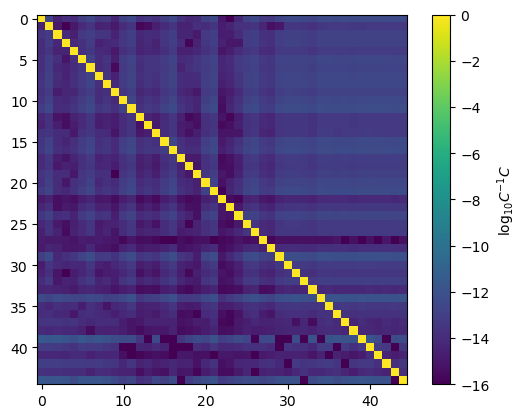

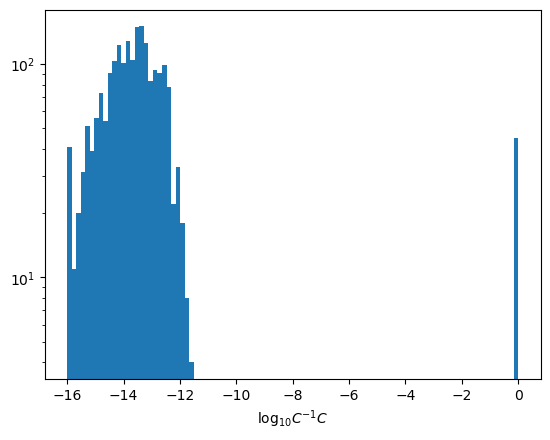

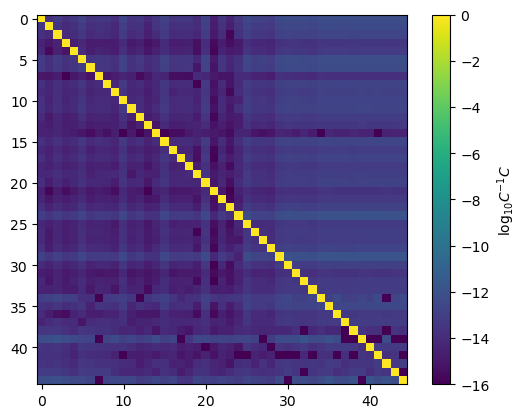

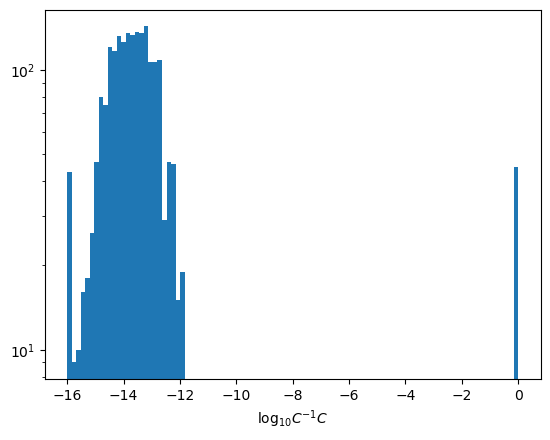

In [25]:
PS_2D_Evol_L1L2_Fisher,PS_2D_Evol_L1L2_Fisher_Inv,samples = get_fisher(PS_2D_Evol_L1L2[:,:,:,:],L1L2_PS_2D_Morlet_FID_stat,3)
PS_2D_Evol_L2_Fisher,PS_2D_Evol_L2_Fisher_Inv,samples = get_fisher(PS_2D_Evol_L2[:,:,:,:],L2_PS_2D_Morlet_FID_stat,3)

Condition Number: 10^4.458


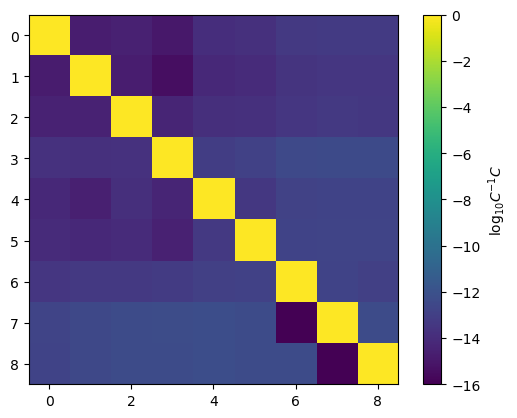

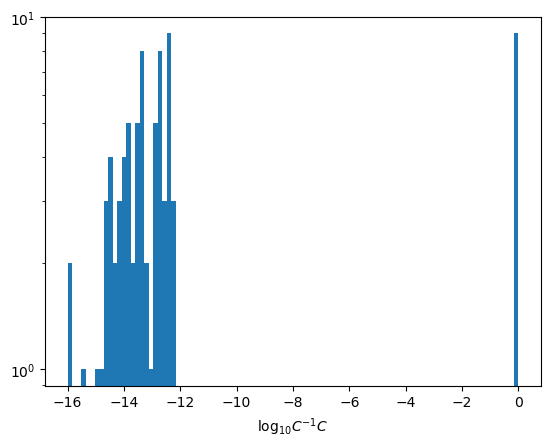

In [28]:
PS_3D_Fisher,PS_3D_Fisher_Inv,samples = get_fisher(PS_3D_derivs[:,:,:-kbins_removed],ps_3d_FID_stat,3)


# Convergence Plots 

In [57]:
PS_2D_Evol_L1L2_Converge = get_convergences(PS_2D_Evol_L1L2_Fisher)
PS_2D_Evol_L2_Converge = get_convergences(PS_2D_Evol_L2_Fisher)
PS_3D_Converge = get_convergences(PS_3D_Fisher)


Full_Stat_Convergence = [PS_2D_Evol_L2_Converge,PS_2D_Evol_L1L2_Converge,
                         PS_3D_Converge]
labels = ['2D Evolved PS \n  $\ell^2$-norm, j= 1,2,3,4','2D PS \n $\ell^1$-norm + $\ell^2$-norm, j= 1,2','Spherically-Averaged 3D PS']

/Users/ianhothi/anaconda3/envs/pywst/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


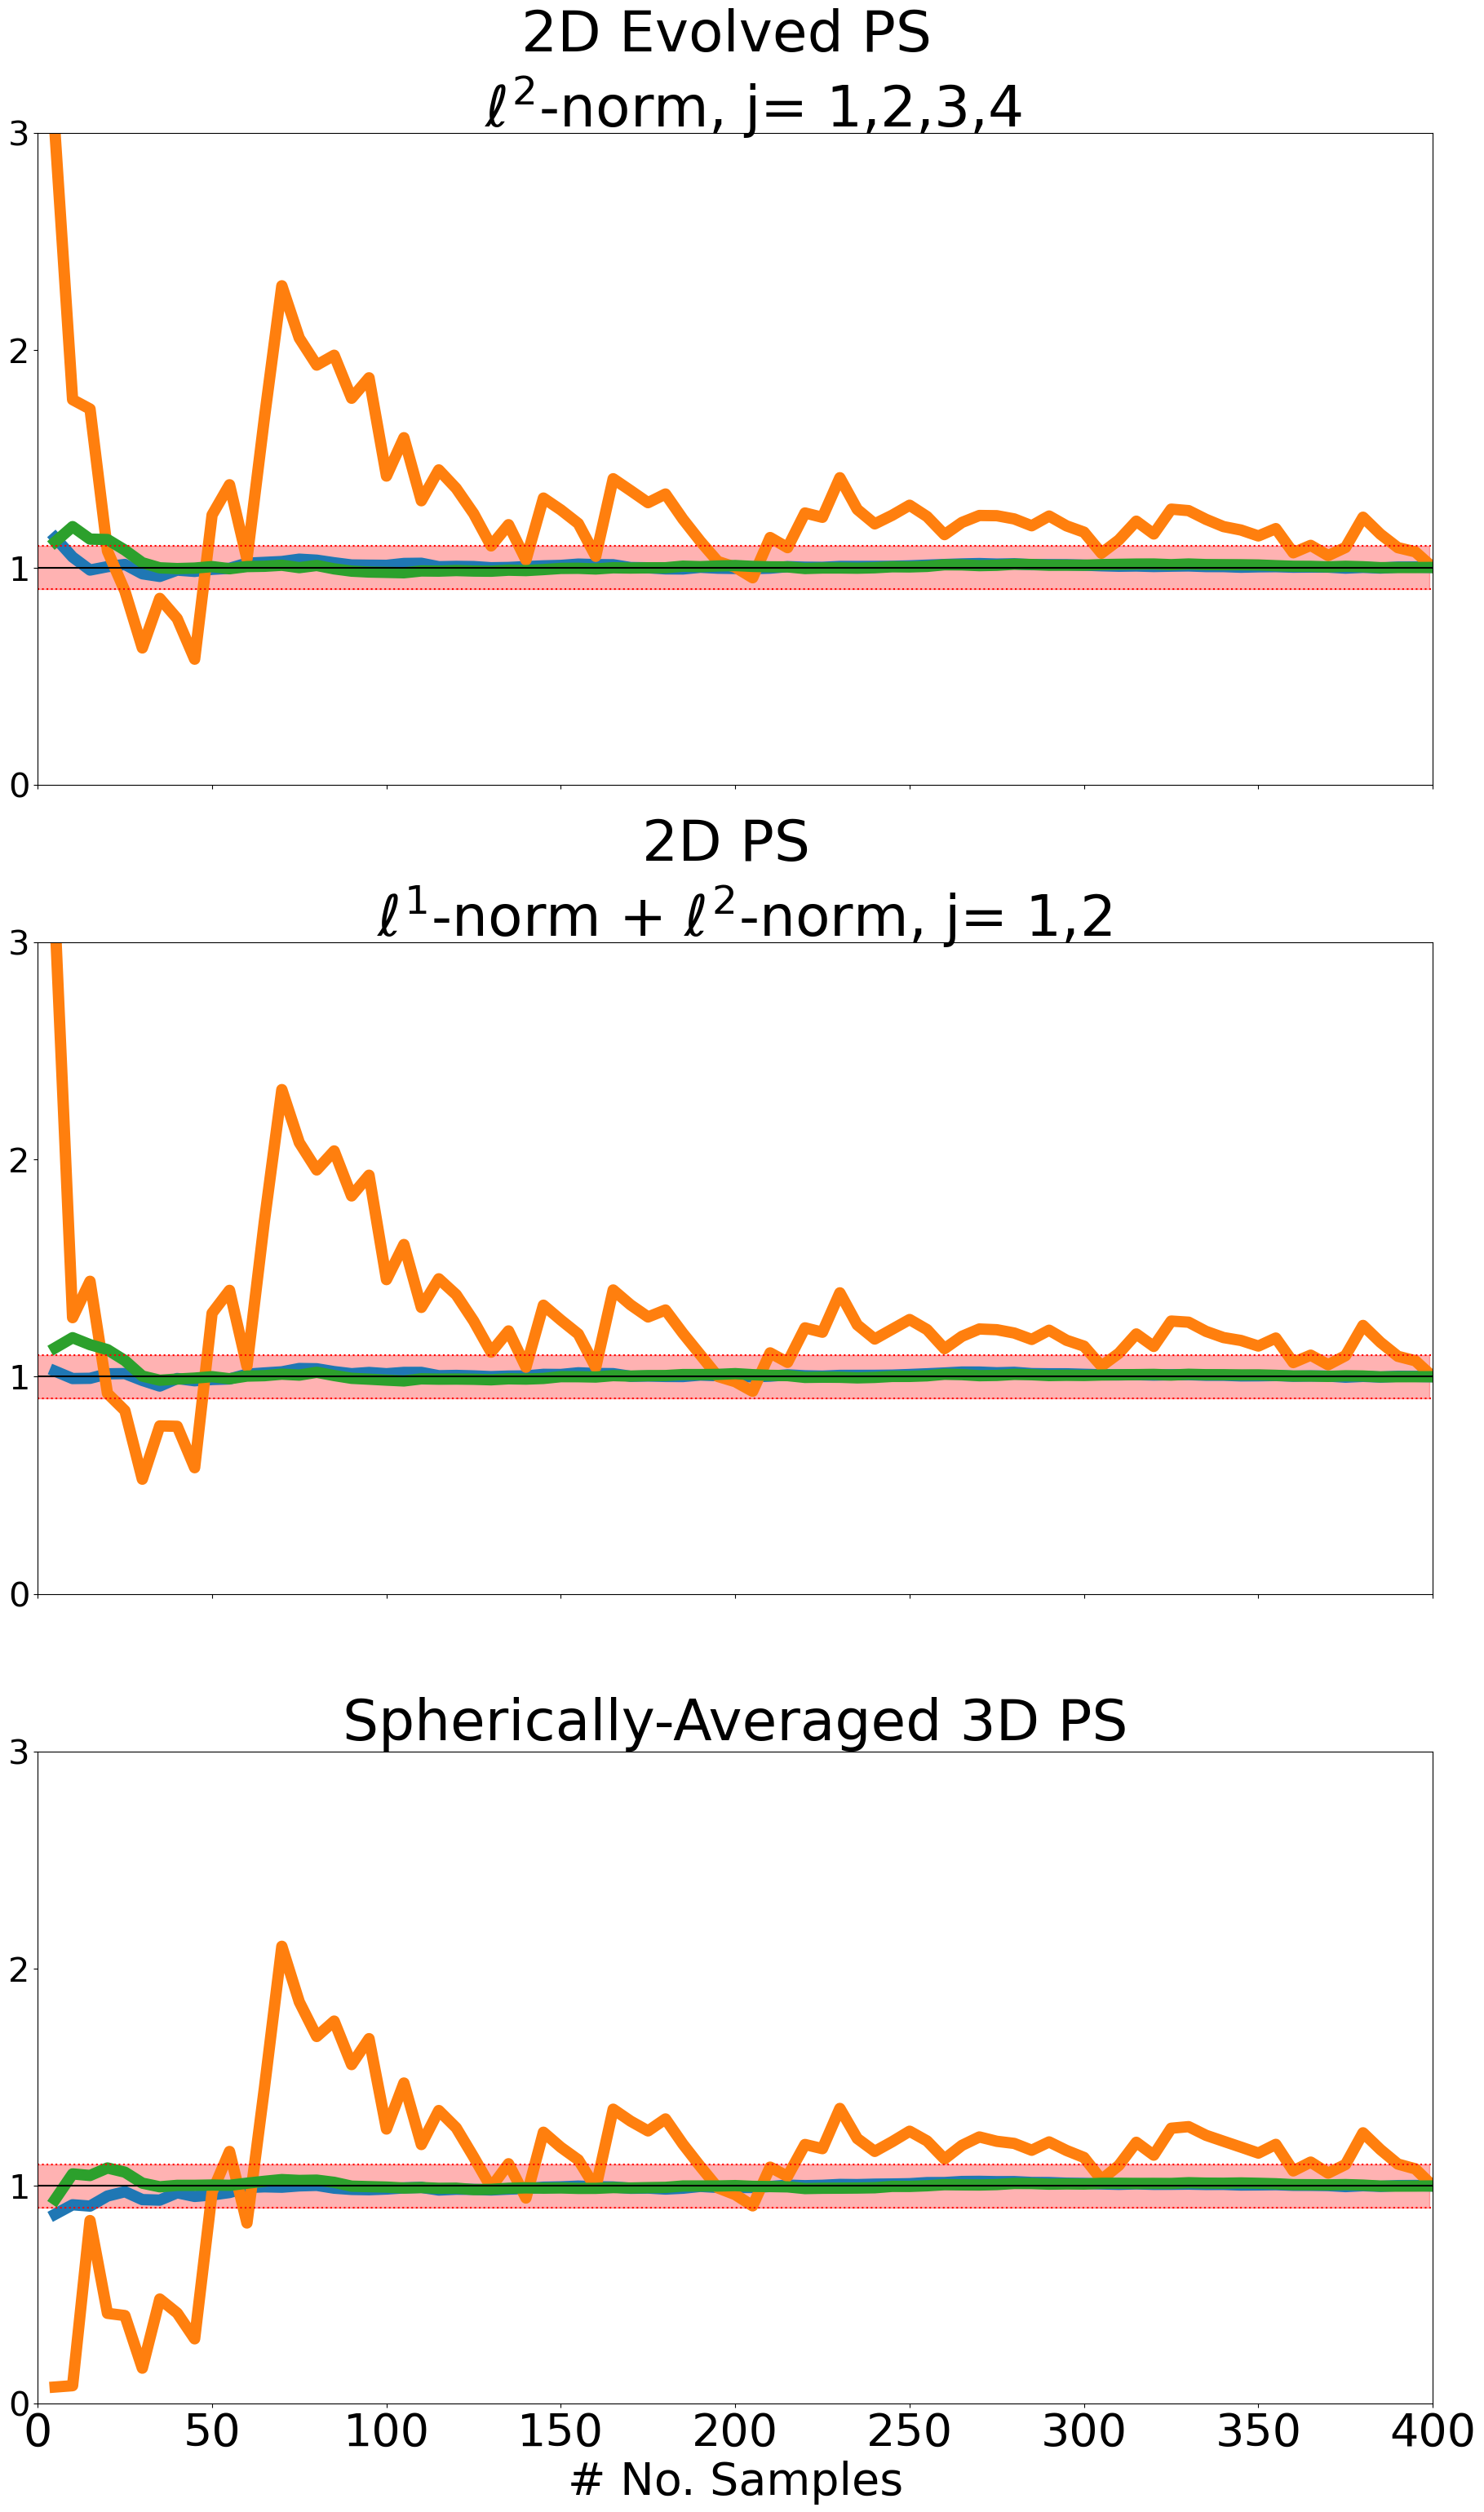

In [58]:
Fisher_Param = ['$T_{Vir}$','$R_{Max}$','$\zeta$']
plot_generic(Full_Stat_Convergence, labels, Fisher_Param,samples,ddir+'/Test_Full_Convergence_Plots.pdf')

# Plotting Fisher

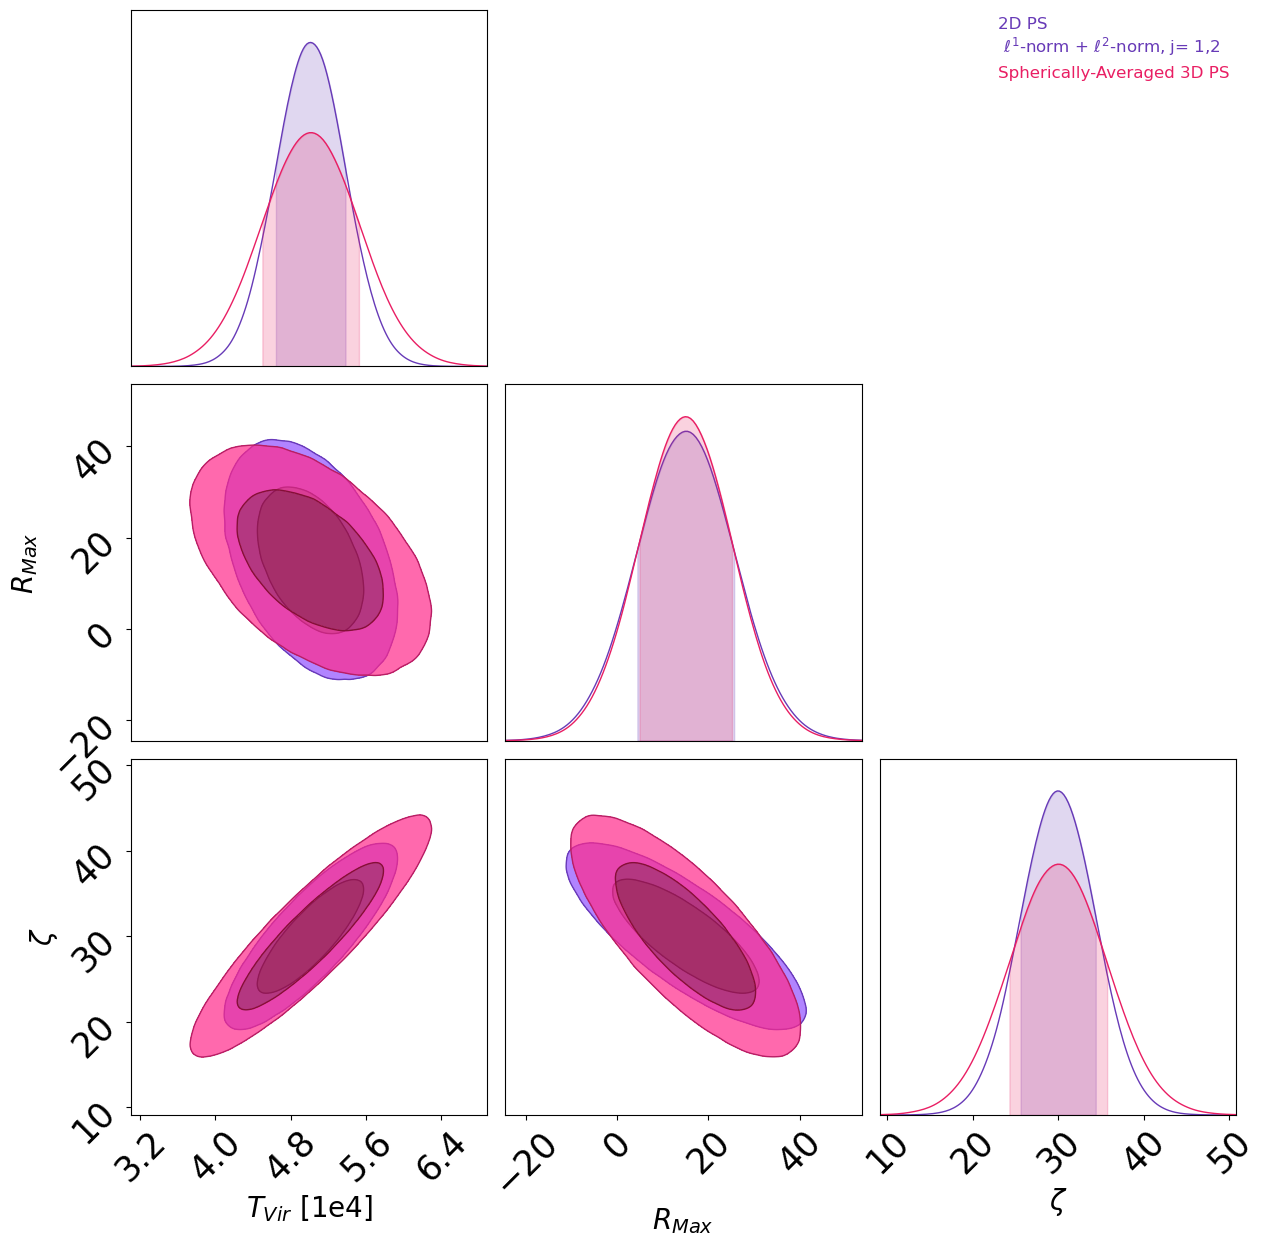

In [59]:
Fisher_Param = ['$T_{Vir}$','$R_{Max}$','$\zeta$']
Summary_Param = ['T_{Vir}','R_{Max}','\zeta']

from chainconsumer import ChainConsumer
fid = [pow(10,4.7),15,30]

c = ChainConsumer()
c.add_covariance(fid,PS_2D_Evol_L1L2_Fisher_Inv[-1], parameters=Fisher_Param,shade=True,name=labels[1],color='purple')
c.add_covariance(fid,PS_3D_Fisher_Inv[-1], parameters=Fisher_Param,shade=True,name=labels[2],color='m')
fig = c.plotter.plot(figsize='PAGE')
fig.set_size_inches(3 + fig.get_size_inches())  


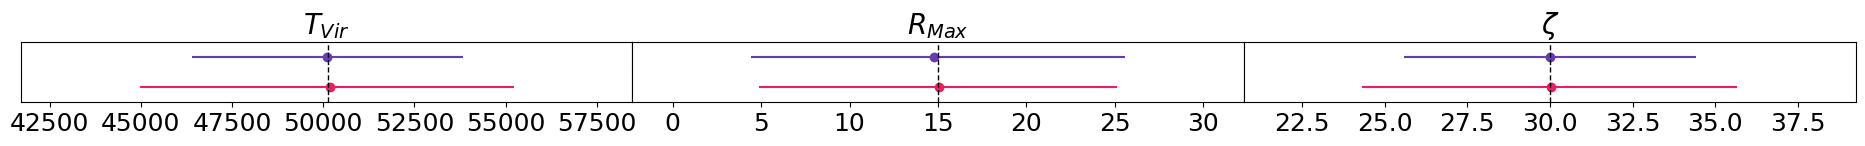

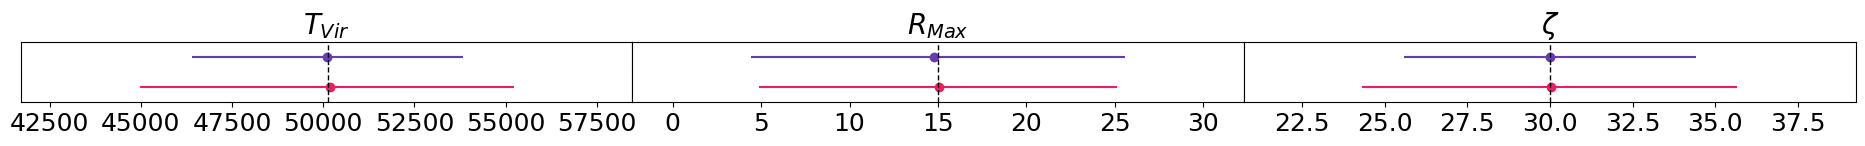

In [60]:
Fisher_Param = ['$T_{Vir}$','$R_{Max}$','$\zeta$']
Summary_Param = ['T_{Vir}','R_{Max}','\zeta']

from chainconsumer import ChainConsumer
fid = [pow(10,4.7),15,30]

c = ChainConsumer()
c.add_covariance(fid,PS_2D_Evol_L1L2_Fisher_Inv[-1], parameters=Summary_Param,shade=True,name='',color='purple')
c.add_covariance(fid,PS_3D_Fisher_Inv[-1], parameters=Summary_Param,shade=True,name='',color='m')

c.plotter.plot_summary(errorbar=True,truth = fid,extra_parameter_spacing=6,show_names = False,parameters=Summary_Param)
